# Importing Libraries

In [2]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Source Analysis

In [3]:
df = pd.read_csv("data_log.csv")
df["mining_time"] = pd.to_datetime(df["mining_time"], format="%Y-%m-%d %H:%M:%S")
df["creation_time"] = pd.to_datetime(df["creation_time"], format="%Y-%m-%d %H:%M:%S.%f")
df["received_time"] = pd.to_datetime(df["received_time"], format="%Y-%m-%d %H:%M:%S.%f")

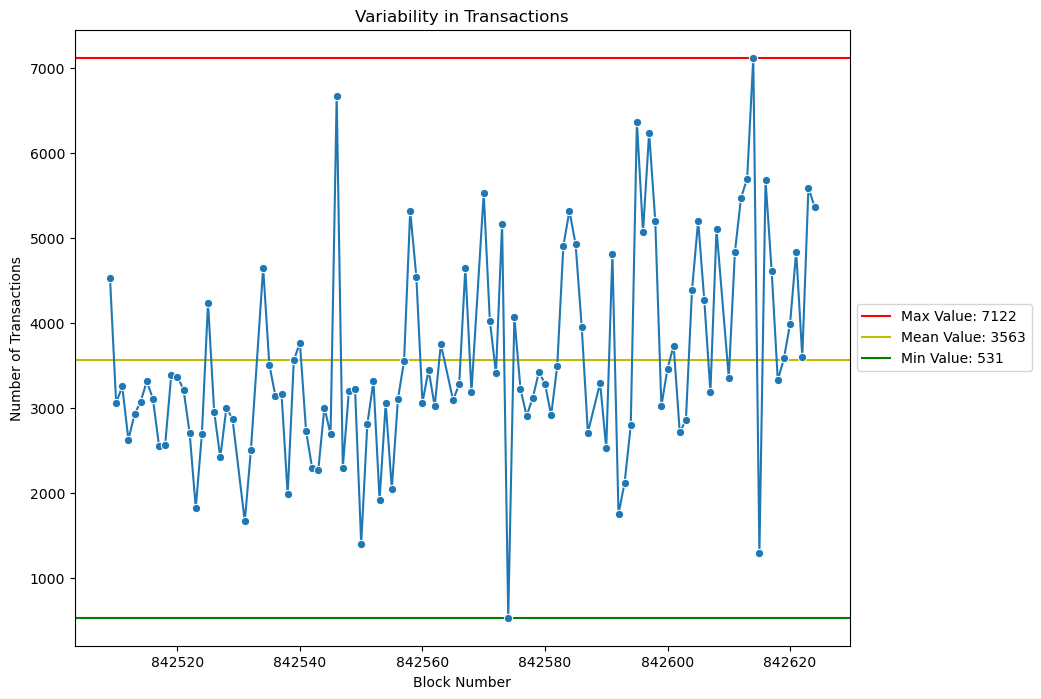

In [4]:
plt.figure(figsize=(10, 8))

plt.axhline(y=df["transactions"].max(), color="r", label=f"""Max Value: {df["transactions"].max()}""")
plt.axhline(y=df["transactions"].mean(), color="y", label=f"""Mean Value: {int(df["transactions"].mean())}""")
plt.axhline(y=df["transactions"].min(), color="g", label=f"""Min Value: {df["transactions"].min()}""")
sns.lineplot(data=df, x="block", y="transactions", marker="o")
plt.title("Variability in Transactions")
plt.ylabel("Number of Transactions")
plt.xlabel("Block Number")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

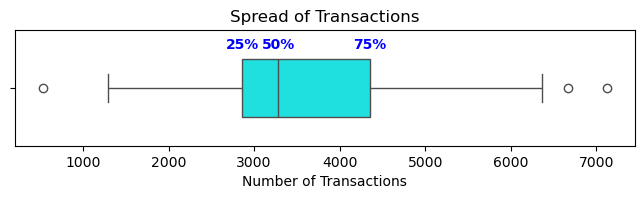

In [5]:
plt.figure(figsize=(8, 1.5))
ax = sns.boxplot(data=df, x="transactions", color="cyan", width=0.5)

Q1 = df['transactions'].quantile(0.25)
Q2 = df['transactions'].quantile(0.50)
Q3 = df['transactions'].quantile(0.75)

top = ax.get_ylim()[1] * 0.75
plt.text(Q1, top, '25%', ha="center", va="center", color="blue", weight="bold")
plt.text(Q2, top, '50%', ha="center", va="center", color="blue", weight="bold")
plt.text(Q3, top, '75%', ha="center", va="center", color="blue", weight="bold")

plt.title("Spread of Transactions")
plt.xlabel("Number of Transactions")
plt.show()

In [6]:
df.sort_values(by=["block"], ascending=True, inplace=True)
df["block_time_difference"] = np.floor(df["creation_time"].diff().dt.total_seconds() / 60)
df["block_time_difference"].fillna(df["block_time_difference"].mean(), inplace=True)
df["block_time_difference"] = df["block_time_difference"].astype(int)

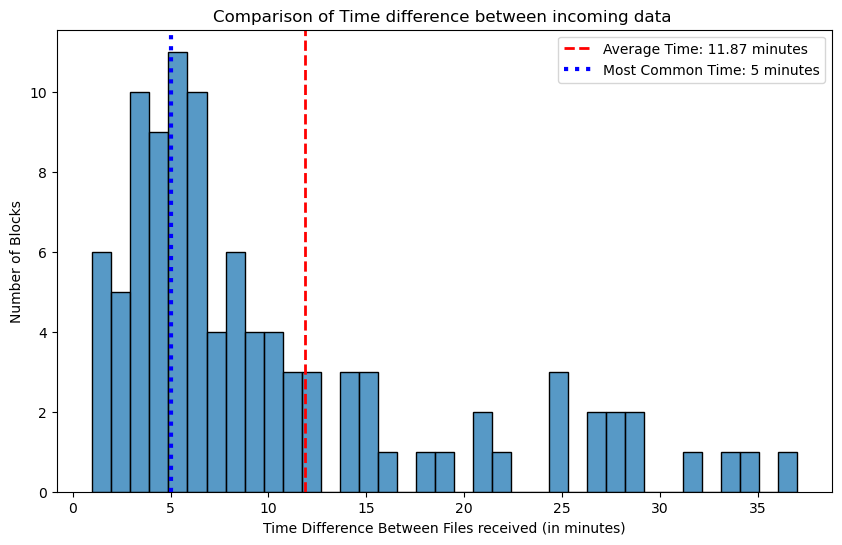

In [7]:
plt.figure(figsize=(10, 6))
filtered_df = df[df["block_time_difference"] <= 40]
sns.histplot(filtered_df["block_time_difference"][:100], bins=len(range(0, filtered_df["block_time_difference"][:100].max())))

average_value = df["block_time_difference"][:100].mean()
plt.axvline(x=average_value, color="red", linestyle="dashed", linewidth=2, label=f"Average Time: {average_value:.2f} minutes")

mode_value = df["block_time_difference"][:100].mode().iloc[-1]
plt.axvline(x=mode_value, color="blue", linestyle="dotted", linewidth=3, label=f"Most Common Time: {mode_value:.0f} minutes")

plt.xlabel("Time Difference Between Files received (in minutes)")
plt.ylabel("Number of Blocks")
plt.title("Comparison of Time difference between incoming data ")
plt.legend()
plt.show()

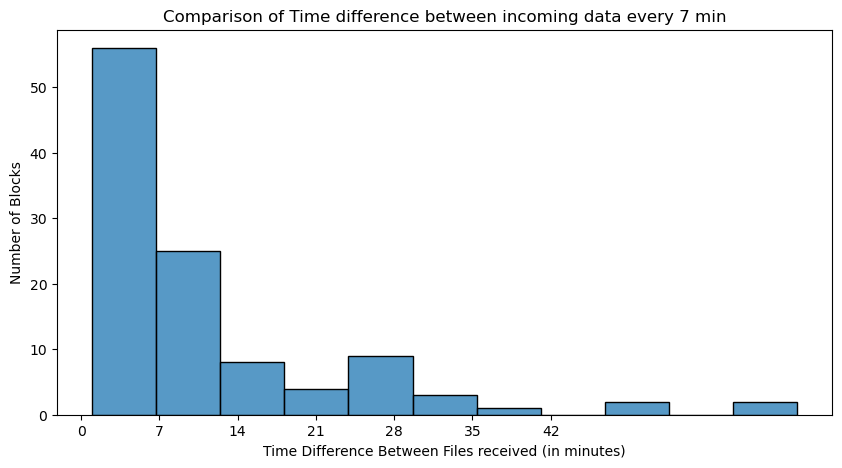

In [8]:
plt.figure(figsize=(10, 5))
sns.histplot(df["block_time_difference"], bins=11)

plt.xticks([0, 7, 14, 21, 28, 35, 42])
plt.xlabel("Time Difference Between Files received (in minutes)")
plt.ylabel("Number of Blocks")
plt.title("Comparison of Time difference between incoming data every 7 min")
plt.show()

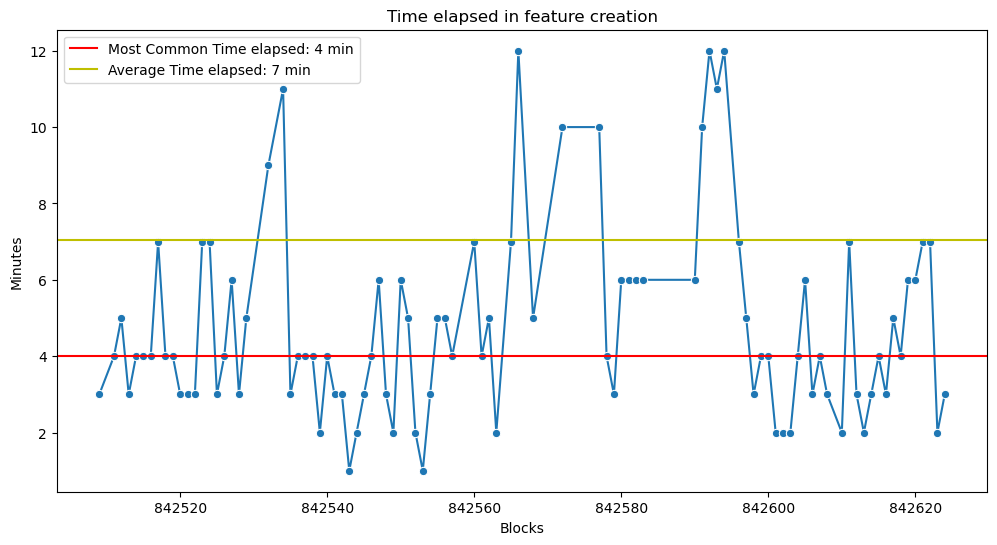

In [9]:
df["feature_time_elapsed"] = df["creation_time"] - df["mining_time"]
df["feature_time_elapsed"] = np.floor(df["feature_time_elapsed"].dt.total_seconds() / 60)
data = df[df["feature_time_elapsed"] <= 12]

plt.figure(figsize=(12, 6))
sns.lineplot(data=data, x="block", y="feature_time_elapsed", marker="o")
plt.axhline(y=df["feature_time_elapsed"].mode().iloc[-1], color="r", label=f"""Most Common Time elapsed: {int(df["feature_time_elapsed"].mode().iloc[-1])} min""")
plt.axhline(y=df["feature_time_elapsed"].mean(), color="y", label=f"""Average Time elapsed: {int(df["feature_time_elapsed"].mean())} min""")
plt.title("Time elapsed in feature creation")
plt.xlabel("Blocks")
plt.ylabel("Minutes")
plt.legend()
plt.show()

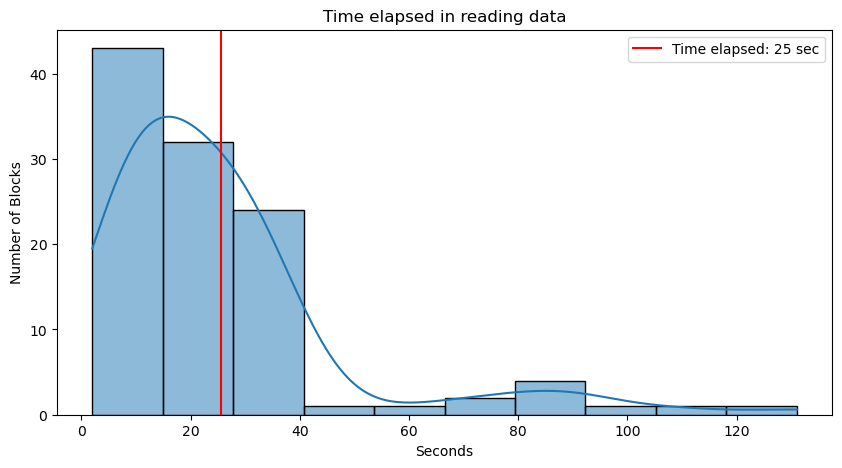

In [10]:
df["time_elapsed"] = df["received_time"] - df["creation_time"]
df["time_elapsed"] = np.floor(df["time_elapsed"].dt.total_seconds())

plt.figure(figsize=(10, 5))
sns.histplot(df["time_elapsed"], kde=True, bins=10)
plt.axvline(x=df["time_elapsed"].mean(), color="r", label=f"""Time elapsed: {int(df["time_elapsed"].mean())} sec""")
plt.title("Time elapsed in reading data")
plt.xlabel("Seconds")
plt.ylabel("Number of Blocks")
plt.legend()
plt.show()

## Storage Analysis

In [11]:
source_df = pd.DataFrame(columns=["block", "transactions", "vin", "vout"])

folder_path = r"C:\Users\jaske\Downloads\rpc_api_data"
files = [f for f in os.listdir(folder_path) if f.endswith(".json")]

for file in files:
    file_path = os.path.join(folder_path, file)
    with open(file_path, "r") as json_file:
        json_data = json.load(json_file)

    vin_add = 0
    vout_add = 0
    for transaction in json_data["transactions"][1:]:
        vin_add = vin_add + len(transaction["vin"])
        vout_add = vout_add + len(transaction["vout"])
    
    source_df = source_df._append({"block": file.replace(".json", ""), "transactions": len(json_data["transactions"][1:]), "vin": vin_add, "vout": vout_add}, ignore_index=True)

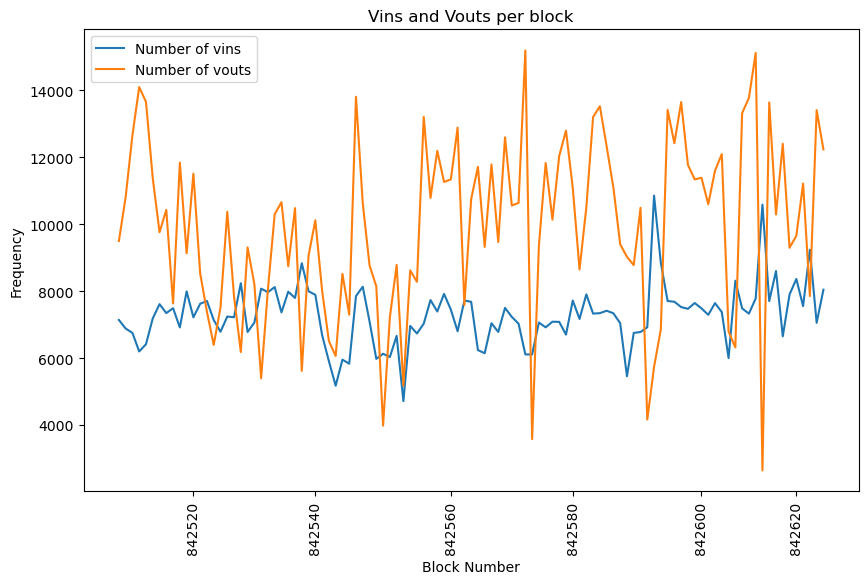

In [12]:
plt.figure(figsize=(10, 6))

sns.lineplot(data=source_df, x="block", y="vin", label="Number of vins")
sns.lineplot(data=source_df, x="block", y="vout", label="Number of vouts")
plt.title("Vins and Vouts per block")
plt.ylabel("Frequency")
plt.xlabel("Block Number")
plt.xticks(ticks=[block for block in source_df["block"] if int(block) % 20 == 0], rotation=90)
plt.legend()
plt.show()

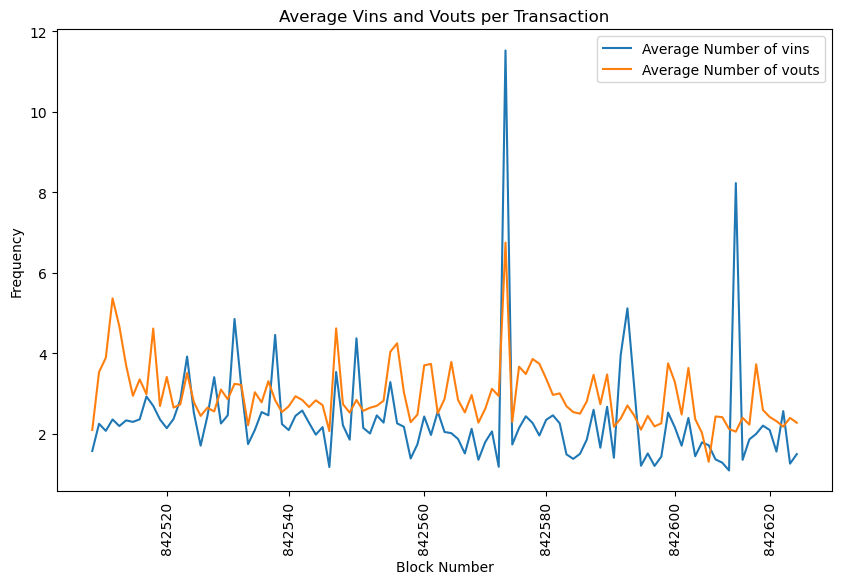

In [13]:
source_df["vin_per"] = source_df["vin"] / source_df["transactions"]
source_df["vout_per"] = source_df["vout"] / source_df["transactions"]

plt.figure(figsize=(10, 6))

sns.lineplot(data=source_df, x="block", y="vin_per", label="Average Number of vins")
sns.lineplot(data=source_df, x="block", y="vout_per", label="Average Number of vouts")
plt.title("Average Vins and Vouts per Transaction")
plt.ylabel("Frequency")
plt.xlabel("Block Number")
plt.xticks(ticks=[block for block in source_df["block"] if int(block) % 20 == 0], rotation=90)
plt.legend()
plt.show()

In [14]:
# db = mysql.connector.connect(
#     host="127.0.0.1",
#     port=3306,
#     user="root",
#     passwd="userroot",
#     database="bitcoin"
# )
# cursor = db.cursor()

# folder_path = r"C:\Users\jaske\Downloads\rpc_api_data"
# files = [f for f in os.listdir(folder_path) if f.endswith(".json")]

# for file in files:
#     file_path = os.path.join(folder_path, file)
#     print(file_path)
#     with open(file_path, "r") as json_file:
#         json_data = json.load(json_file)
    
#     block_info = json_data["block_info"]
#     query = """
#     INSERT INTO bitcoin.blocks (
#         difficulty, block_hash, height, mediantime, merkleroot, nTx, 
#         block_number, previousblockhash, size, strippedsize, block_time, weight
#     ) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
#     """
#     values = (
#         block_info['difficulty'],
#         block_info['hash'],
#         str(block_info['height']),
#         str(block_info['mediantime']),
#         block_info['merkleroot'],
#         str(block_info['nTx']),
#         str(block_info['height']),
#         block_info['previousblockhash'],
#         str(block_info['size']),
#         str(block_info['strippedsize']),
#         str(block_info['time']),
#         str(block_info['weight'])
#     )
#     cursor.execute(query, values)
#     db.commit()

#     for transaction in json_data["transactions"][1:]:
#         query = """
#         INSERT INTO bitcoin.transactions (
#             block_number, fee, size, transaction_time, total_bitcoin_transacted, txid, weight
#         ) VALUES (%s, %s, %s, %s, %s, %s, %s)
#         """
#         values = (
#             block_info["height"],
#             transaction['fee'],
#             str(transaction['size']),
#             str(block_info['time']),
#             transaction['total_bitcoin_transacted'],
#             transaction['txid'],
#             transaction['weight']
#         )
#         cursor.execute(query, values)
#         db.commit()
        
#         query = """
#         INSERT INTO bitcoin.vin_add (txid, address, vin_txid, vin_value, transaction_type)
#         VALUES (%s, %s, %s, %s, %s)
#         """
#         values_list = []
#         for vin_data in transaction["vin"]:
#             values = (
#                 transaction['txid'],
#                 vin_data['address'],
#                 vin_data['txid'],
#                 vin_data['value'],
#                 vin_data['Transaction_type']
#             )
#             values_list.append(values)
#         cursor.executemany(query, values_list)
#         db.commit()

#         query = """
#         INSERT INTO bitcoin.vout_add (txid, address, is_utxo, vout_value, transaction_type)
#         VALUES (%s, %s, %s, %s, %s)
#         """
#         values_list = []
#         for vout_data in transaction["vout"]:
#             values = (
#                 transaction['txid'],
#                 vout_data.get("scriptPubKey", {}).get("address", "none"),
#                 vout_data['is_utxo'],
#                 vout_data['value'],
#                 vout_data['Transaction_type']
#             )
#             values_list.append(values)
#         cursor.executemany(query, values_list)
#         db.commit()

In [15]:
import os
import sys

df = pd.DataFrame(columns=["block", "original", "pruned"])
folder_path = r"C:\Users\jaske\Downloads\rpc_api_data"
files = os.listdir(folder_path)

for file in files:
    count = 0
    file_path = os.path.join(folder_path, file)
    with open(file_path, "r") as json_file:
        content = json.load(json_file)
        original = sys.getsizeof(str(content))
        for transaction in content["transactions"][1:]:
            transaction.pop("hex", None)
            transaction.pop("hash", None)
            transaction["vin"] = [{k: v for k, v in data.items() if k not in ["scriptSig", "txinwitness"]} for data in transaction["vin"]]
            count = count + sys.getsizeof(str(transaction))
        df = df._append({"block": int(file.replace(".json", "")), "original": original, "pruned": count}, ignore_index=True)

df["original"] = df["original"] / (1024*1024)
df["pruned"] = df["pruned"] / (1024*1024)

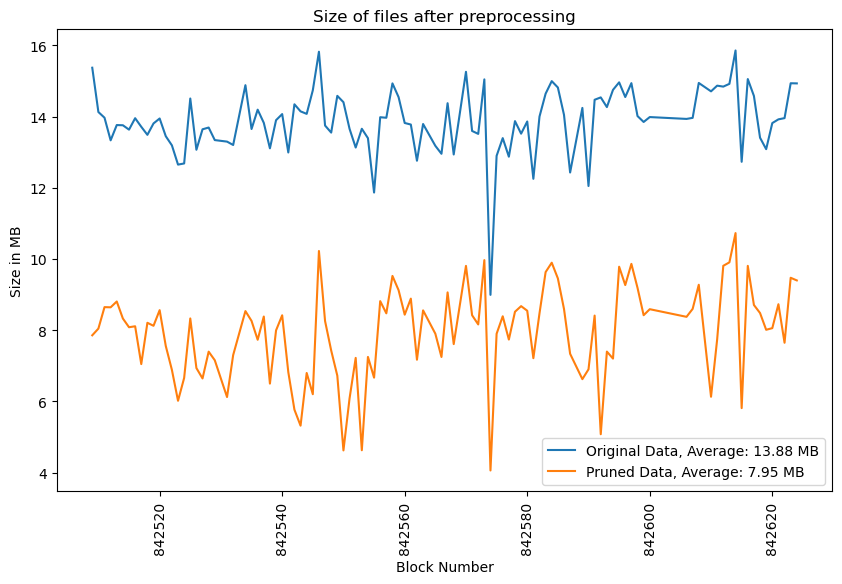

In [16]:
plt.figure(figsize=(10, 6))

sns.lineplot(data=df, x="block", y="original", label=f"""Original Data, Average: {round(np.mean(df["original"]), 2)} MB""")
sns.lineplot(data=df, x="block", y="pruned", label=f"""Pruned Data, Average: {round(np.mean(df["pruned"]), 2)} MB""")
plt.title("Size of files after preprocessing")
plt.ylabel("Size in MB")
plt.xlabel("Block Number")
plt.xticks(ticks=[block for block in df["block"] if int(block) % 20 == 0], rotation=90)
plt.legend()
plt.show()